# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for Radiation Data as it comes off a HOBO logger.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
import pandas as pd
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2023/Moorings/23bspr2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/hobo/23bspr2a_par_rad_24hr.csv'
instrument = 'hobo'
mooring_meta_file = user_data_dir+'logs/23BSPR-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/telos_wx_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'hobo'
###############################################################


#init and load data
#10min or 1hr data are available usually from telos driven met packages
rad_df = pd.read_csv(datafile,skiprows=1,parse_dates=True, index_col='Date Time, GMT+00:00')

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_41059/3859248977.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rad_df = pd.read_csv(datafile,skiprows=1,parse_dates=True, index_col='Date Time, GMT+00:00')


In [4]:
rad_df.columns = [x.split(',')[0] for x in rad_df.columns]
rad_df.index.name = 'date_time'
rad_df.sample(3)

,#,Solar Radiation,PAR
date_time,,,
2023-09-01 15:30:01,19114,0.6,1.2
2023-07-06 23:30:01,10954,458.1,1176.2
2023-07-11 02:10:01,11546,143.1,396.2


In [5]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


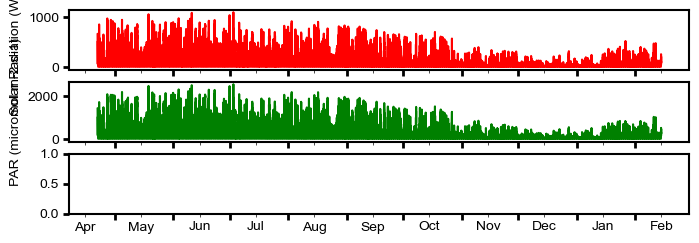

In [6]:
fig, ax = plt.subplots(3,figsize=(8, 3),sharex=True)
rad_df['Solar Radiation'].dropna().plot(ax=ax[0],c='r')
ax[0].set_ylabel('Solar Radiation (W m-2)')
rad_df.PAR.dropna().plot(ax=ax[1],c='g')
ax[1].set_ylabel('PAR (micromol m-2 s-1)')


ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))

In [7]:
## Modify the raw file for whatever remaing QC you want to apply

In [8]:
rad_df.columns

Index(['#', 'Solar Radiation', 'PAR'], dtype='object')

In [9]:
## change variable names if needed to match TELOS yaml expectations

In [10]:
rad_df.index = rad_df.index.rename('date_time')
rad_df = rad_df.rename(columns={'BaroPres':'pressure',
                                'Temperature':'PAR_Temp',
                                  'Air_Temp':'temperature',
                                  'U_wind':'northward_wind',
                                  'V_wind':'eastward_wind',
                                  'Wind_Speed':'wind_speed_',
                                  'Gust':'wind_speed_gust',
                                  'RH':'relative_humidity',
                                'wind_from_direction':'wind_direction',
                                'Solar Radiation':'swrad',
                                'PAR':'par'
                                  })
rad_df.sample()

,#,swrad,par
date_time,,,
2023-11-14 20:30:01,29800,15.6,43.7


## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [11]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [12]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [13]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [14]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
met_wop_nc = ncCFsave.EcoFOCI_CFnc(df=rad_df, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
met_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [15]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
met_wop_nc.expand_dimensions()

In [16]:
met_wop_nc.variable_meta_data(variable_keys=list(rad_df.columns.values),drop_missing=True)
# met_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
met_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [18]:
#add global attributes
met_wop_nc.deployment_meta_add()
met_wop_nc.get_xdf()

#add instituitonal global attributes
met_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
# met_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
met_wop_nc.provinance_meta_add()

#provide intial qc status field
met_wop_nc.qc_status(qc_status='unknown')

In [19]:
met_wop_nc.get_xdf()

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 43059, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time       (time) datetime64[ns] 344kB 2023-04-21T22:00:01 ... 2024-02-14...
  * latitude   (latitude) float64 8B 1e+35
  * longitude  (longitude) float64 8B 1e+35
  * depth      (depth) float64 8B 1e+35
Data variables:
    swrad      (time, depth, latitude, longitude) float64 344kB 669.4 ... 105.6
    par        (time, depth, latitude, longitude) float64 344kB 1.434e+03 ......
Attributes: (12/28)
    MooringID:                              23BSPR-2A
    platform_deployment_date:               2023-04-30T23:15:00Z
    platform_deployment_cruise_name:        DY2306
    platform_recovery_date:                 2024-02-13T00:00:00Z
    platform_recovery_cruise_name:          RP2401
    platform_deployment_recovery_comments:  Release would not talk during ini...
    ...                                     ...
    references:                             
    citation:                               
    acknowledgement:                        
    date_created:                           2025-04-02T09:07:23Z
    date_modified:                          
    QC_indicator:                           unknown

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [42]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = ''
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'.nc'
met_wop_nc.xarray2netcdf_save(xdf = met_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'seconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})
